In [1]:
import os
import argparse

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

here you can find a checkpoint of deeplab trained on coco + scannet
(without towels and the 3 other-* classes):

In [2]:
BASE = '/home/he/projects/cl_seg/src/deeplab'
RESUME = '2987_deeplab_scannet_best.pth'

In [3]:
model = torchvision.models.segmentation.deeplabv3_resnet101(
    pretrained=False,
    pretrained_backbone=False,
    progress=True,
    num_classes=40,
    aux_loss=None)
ckpt_path = os.path.join(BASE, RESUME)
checkpoint = torch.load(ckpt_path)
# remove any aux classifier stuff
removekeys = [
    key for key in checkpoint.keys() if key.startswith('aux_classifier')
]
for key in removekeys:
    del checkpoint[key]
model.load_state_dict(checkpoint, strict=True)
model.to('cuda')
model.eval()
print("Loaded!")

Loaded!


- output: `(4): Conv2d(256, 40, kernel_size=(1, 1), stride=(1, 1))`

- reference: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

In [4]:
SCANNET_FRAMES_25K_PATH = '/home/he/data/cl_seg/scannet/scannet_frames_25k'
SCENE = 'scene0000_00'
EXAMPLE_IMG = '000000' # from 000000 to 005500

In [5]:
color_img_name = os.path.join(SCANNET_FRAMES_25K_PATH, SCENE, 'color', EXAMPLE_IMG+'.jpg')
lbl_img_name = os.path.join(SCANNET_FRAMES_25K_PATH, SCENE, 'label', EXAMPLE_IMG+'.png')

In [6]:
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

- without Normalize()

In [7]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(color_img_name)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=_imagenet_stats['mean'], std=_imagenet_stats['std']),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# make a prediction
with torch.no_grad():
    output = model(input_batch)['out'][0]
class_predictions = output.argmax(0)

# logits = model(image)['out']
# _, prediction = torch.max(logits, 1)
_, prediction = torch.max(output, 0)

- with Normalize()

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_stats['mean'], std=_imagenet_stats['std']),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# make a prediction
with torch.no_grad():
    output = model(input_batch)['out'][0]
class_predictions2 = output.argmax(0)

# logits = model(image)['out']
# _, prediction = torch.max(logits, 1)
_, prediction2 = torch.max(output, 0)

In [9]:
output.shape
output[0,:, :]

tensor([[-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        [-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        [-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        ...,
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906],
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906],
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906]],
       device='cuda:0')

In [10]:
prediction_np = class_predictions.cpu().detach()
print(np.unique(prediction_np))

[ 0  1  3  4  5  6  7  9 13 14 16 20 21 31 34 36]


In [11]:
from viz_label import create_color_palette

- viz without Normalize()

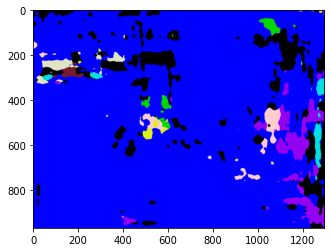

In [12]:
image = class_predictions.cpu().detach()
height = image.shape[0]
width = image.shape[1]
vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    vis_image[image == idx] = color

plt.imshow(vis_image)

- viz with Normalize()

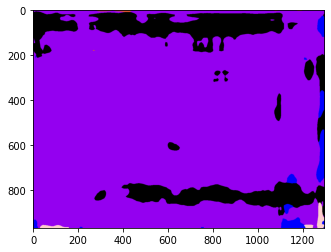

In [13]:
image = class_predictions2.cpu().detach()
height = image.shape[0]
width = image.shape[1]
vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    vis_image[image == idx] = color

plt.imshow(vis_image)

- vis label image

In [14]:
lbl_image = Image.open(lbl_img_name)
lbl_image = np.asarray(lbl_image)
lbl_image
print(np.unique(lbl_image))

[ 0  1  2  3  7 14 16]


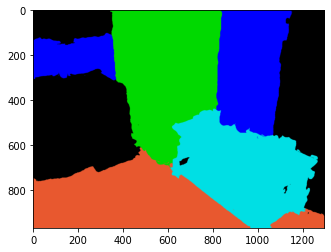

In [15]:

height = lbl_image.shape[0]
width = lbl_image.shape[1]
lbl_vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    lbl_vis_image[lbl_image == idx] = color

plt.imshow(lbl_vis_image)

In [15]:
# import imageio
# imageio.imwrite(filename, vis_image)

In [16]:
# # create a color pallette, selecting a color for each class
# palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
# colors = (colors % 255).numpy().astype("uint8")

# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(class_predictions.byte().cpu().numpy()).resize(input_image.size)
# r.putpalette(colors)

# plt.imshow(r)